# F5c ionic current analysis for tRNAs

This notebooks aims to use the f5c eventalign tsv output (see: https://github.com/hasindu2008/f5c) to subsequently apply statistical comparison of signal levels per reference base position.
Content of this notebook:
1. Import of required python packages
2. Functions
3. Data loading
4. Data preparation
5. Statistical comparison
6. Visualisation

## 1. Import of required python packages

In [1]:
# ---- General packages ----
import logging
import pickle
import numpy as np
import pandas as pd
import pingouin as pg
from datetime import datetime
import polars as pl
import patchworklib as pw

# ---- For plotting ----
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns


# ---- Statistical testing ----
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests


<Figure size 100x100 with 0 Axes>

## 2. Functions

### Analysis functions

In [6]:
def convert_kmers_to_base_positions(
    df, 
    center_index =5):

    """
    Goal: this function assigns the mean signal level per k-mer to the center position within k-mer.
    Parameters:
        df: pd.DataFrame, made from .tsv output of f5c
        center_index: int, the index of the center base position within k-mer
    """
    # Add column with the center base position
    df = df.rename(columns={'position': 'kmer_position'})
    kmer_positions = df['kmer_position']
    kmer_positions_list = list(kmer_positions)
    base_positions_list = [kmer_position + center_index for kmer_position in kmer_positions]
    df.insert(2, "base_position", base_positions_list)

    # Add column with the center base
    reference_kmers = df['reference_kmer']
    reference_kmers_list = list(reference_kmers)
    reference_base_list = [reference_kmer[center_index] for reference_kmer in reference_kmers_list]
    df.insert(4, "reference_base", reference_base_list)

    return df

In [7]:
def compute_MWU_results(
    f5c_output_1,
    f5c_output_2,
    common_positions_list,
    samples_labels,
    ):
    """
    Goal: apply Mann-Whitney-U testing for the two samples with subsequent FDR-correction
    Parameters:
        f5c_output_1/2: pd.DataFrame, made of .tsv output of f5c eventalign, which include signal levels per base position
        common_positions_list: list[int], list of position indices which are included in both f5c .tsv outputs
        samples_labels: list[str], list of names of samples
    """

    Mann_Whitney_U_results = []
    for position in common_positions_list:
        # Make subset of the signals for specific base_position
        subset_1 = f5c_output_1[f5c_output_1['base_position']==position]
        subset_2 = f5c_output_2[f5c_output_2['base_position']==position]
        # Get all the signal levels at this specific base position
        signal_levels_1 = subset_1['event_level_mean']
        signal_levels_2 = subset_2['event_level_mean']
   
        # With these do Mann-Whitney-U test
        ## Drop the reads NA entries
        data_1 =  signal_levels_1.dropna()
        data_2 =  signal_levels_2.dropna()
        ## Only when the threshold of minimum amount of reads is reached
        if (len(data_1) >= min_reads) and (len(data_2) >= min_reads):
            result_mwu = pg.mwu(data_1, data_2, alternative='two-sided')
            stat = result_mwu['U-val'].values[0]
            pval = result_mwu['p-val'].values[0]
            RBC = result_mwu['RBC'].values[0]
            Mann_Whitney_U_results.append({'base_position': position,
                                   'p_value': pval,
                                    'RBC': RBC,
                                  'num_'+ samples_labels[0]: len(signal_levels_1),
                                  'num_' + samples_labels[1]: len(signal_levels_2),
                                  'median_' + samples_labels[0]: np.median(signal_levels_1),
                                  'median_' + samples_labels[1]: np.median(signal_levels_2),
                                   'std_'+ samples_labels[0]: np.std(signal_levels_1),
                                   'std_'+ samples_labels[1]: np.std(signal_levels_2),
                                  })

    results_df = pd.DataFrame(Mann_Whitney_U_results)
    pvals = results_df['p_value']
    # Apply FDR-correction
    _, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh', alpha = 0.01)
    results_df['adjusted_p_value'] = pvals_corrected
    filtered_df = results_df[(results_df['adjusted_p_value'] < threshold)]

    # Get the significant positions
    significant_positions = list(filtered_df['base_position'])
    print(f"Number of significantly different positions for this entry: {len(significant_positions)}")
    
    if len(significant_positions) > 0:
        return filtered_df, significant_positions
    else:
        return None, None

### Plotting functions

#### Line plot

In [2]:
def plot_event_level_means_one_sample_with_seq(
    event_level_df,
    xlim_start=0,
    xlim_end=20,
    max_reads=None,
    alpha_lines=1/200,
    highlight_positions=None,
    color = "#009E73",
    sequence=None 
):
    """
    Plot trimmean signals for 1 sample.
    
    Parameters:
        event_level_df_1: pd.DataFrame with event levels means per read (row) per positoin (column)
        xlim_start/xlim_end: int, x-axis boundaries
        max_reads: int, maximum numbers of reads to plot
        alpha_lines: float, transparency
        sample_labels: list[str], list of 3 labels
        highlight_positions: list[int] list of positions (indices) of interest
        sequence: [str], sequence of region of interest as a list of characters
    """

    print(f"Shape of metric array: {event_level_df.shape}")

    # Limit x-axis range
    plot_positions = [pos for pos in event_level_df.columns]

    plt.figure(figsize=(10, 6))

    # When too many reads, draw random subsample
    if max_reads is not None and len(event_level_df) > max_reads:
        data_to_plot = event_level_df.sample(n=max_reads, random_state=42)
    else:
        data_to_plot = event_level_df

    # Plot each read as single line
    for i in range(len(data_to_plot)):
        plt.plot(plot_positions, data_to_plot[plot_positions].iloc[i], color=color, alpha=alpha_lines)

    print(f"Plotting {len(data_to_plot)} reads")

    # Show both sequence and position if sequence is provided
    if sequence is not None:
        print(f"The sequence being plotted is {len(sequence[xlim_start:xlim_end])} nt")
        
        ax = plt.gca()  # Get current axis

        # x-axis tick positions
        x_positions = list(range(xlim_start, xlim_end))

        if sequence is not None:
            sequence_slice = sequence[xlim_start:xlim_end]
            if len(sequence_slice) != (xlim_end - xlim_start):
                raise ValueError("Length of sequence slice does not match expected range.")

            # Combine sequence and index labels with newline
            combined_labels = [f"{base}\n{idx}" for idx, base in zip(x_positions, sequence_slice)]
            ax.set_xticks(x_positions)
            ax.set_xticklabels(combined_labels)
            ax.set_xlabel("Base (top) and index (bottom)")
        else:
            ax.set_xticks(x_positions)
            ax.set_xticklabels(x_positions)
            ax.set_xlabel("Sequence index")

    else:
        plt.xticks(plot_positions)


    plt.xlim(xlim_start, xlim_end)
    plt.title(reference_of_interest)
    plt.ylim(40, 150)
    plt.ylabel("Event level mean (pA)")
    plt.grid(color='gray', linestyle='-', linewidth=0.3, alpha=1/30)

    if highlight_positions is not None:
        for position in highlight_positions:
            plt.axvspan(position - 0.5, position + 0.5, color='yellow', alpha=0.3)

    plt.tight_layout()
    plt.show()


In [3]:
def plot_event_level_means_two_samples_with_seq(
    event_level_df_1,
    event_level_df_2,
    xlim_start=0,
    xlim_end=20,
    max_reads=None,
    alpha_lines=1/200,
    sample_labels=None,
    highlight_positions= None,
    sequence= None
):
    """
    Plot trimmean signals for 3 samples on the same plot.
    
    Parameters:
        event_level_df_1/2: pd.DataFrame with event levels means per read (row) per positoin (column)
        xlim_start/xlim_end: int, x-axis boundaries
        max_reads: int, maximum numbers of reads to plot
        alpha_lines: float, transparency
        sample_labels: list[str], list of 3 labels
        highlight_positions: list[int] list of positions (indices) of interest
        sequence: [str], sequence of region of interest as a list of characters
    """
    all_metrics = [event_level_df_1, event_level_df_2]
    colors = ['#009E73', "#7851A9"]
    if sample_labels is None:
        sample_labels = ['Sample 1', 'Sample 2']

    plt.figure(figsize=(10, 6))

    for idx, sample in enumerate(all_metrics):
        event_level_data = all_metrics[idx]
        print(f"Shape of metric array {sample_labels[idx]}: { event_level_data.shape}")

        # Downsample if needed
        if max_reads is not None and len(event_level_data) > max_reads:
            data_to_plot =  event_level_data.sample(n=max_reads, random_state=42)
        else:
            data_to_plot =  event_level_data

        for i in range(len(data_to_plot)):
            plt.plot(
                data_to_plot.columns,
                data_to_plot.iloc[i],
                color=colors[idx],
                alpha=alpha_lines,
                label=sample_labels[idx] if i == 0 else ""
            )

        print(f"Plotting {len(data_to_plot)} reads for {sample_labels[idx]}")

    # Show both sequence and position if sequence is provided
    if sequence is not None:
        print(f"The sequence being plotted is {len(sequence[xlim_start:xlim_end])} nt")
        
        ax = plt.gca()  # Get current axis

        # x-axis tick positions
        x_positions = list(range(xlim_start, xlim_end))

        if sequence is not None:
            sequence_slice = sequence[xlim_start:xlim_end]
            if len(sequence_slice) != (xlim_end - xlim_start):
                raise ValueError("Length of sequence slice does not match expected range.")

            # Combine sequence and index labels with newline
            combined_labels = [f"{base}\n{idx}" for idx, base in zip(x_positions, sequence_slice)]
            ax.set_xticks(x_positions)
            ax.set_xticklabels(combined_labels)
            ax.set_xlabel("Base (top) and index (bottom)")
        else:
            ax.set_xticks(x_positions)
            ax.set_xticklabels(x_positions)
            ax.set_xlabel("Sequence index")

    else:
        plt.xticks(plot_positions)
        
    plt.xlim(xlim_start, xlim_end)

    plt.title(reference_of_interest)
    plt.ylabel("Event level mean (pA)")
    plt.grid(color='gray', linestyle='-', linewidth=0.3, alpha=1/30)
    plt.legend()
    plt.tight_layout()

    if highlight_positions is not None:
        for position in highlight_positions:
            plt.axvspan(position-0.5, position+0.5, color='yellow', alpha=0.3)

    plt.show()

#### Scatterplot

In [4]:
def plot_mean_and_sd_of_event_level_two_samples(
    event_level_df_1,
    event_level_df_2,
    xlim_start,
    xlim_end,
    sample_labels,
    colors=None 
):
    """
    Plot dotplots of the mean and sd of the trimmean values per position for 3 samples.
    
    Parameters:
        event_level_df_1/2: pd.DataFrame with event levels means per read (row) per positoin (column)
        xlim_start/xlim_end: x-axis boundaries, define region
        sample_labels: list of 3 labels
        colors: list of colours for each sample: 
    """
    all_metrics = [event_level_df_1,event_level_df_2]
    all_means = []
    all_sds = []

    for i, sample in enumerate(all_metrics):
        event_level_data = sample

        # Mean
        event_level_mean = event_level_data.mean()
        df_mean = pd.DataFrame({
            'position': range(len(event_level_mean)),
            'value': event_level_mean,
            'label': sample_labels[i]
        })
        all_means.append(df_mean)

        # SD
        event_level_sd = event_level_data.std()
        df_sd = pd.DataFrame({
            'position': range(len(event_level_sd)),
            'value': event_level_sd,
            'label': sample_labels[i]
        })
        all_sds.append(df_sd)

    # Combine all
    df_all_means = pd.concat(all_means, ignore_index=True)
    df_all_sds = pd.concat(all_sds, ignore_index=True)


    # Default colors if none given
    if colors is None:
        colors = ['#009E73', "#7851A9"]
    x_ticks = list(range(xlim_start, xlim_end + 1, 5))

    # Filter by xlim
    df_plot_means = df_all_means.query("position >= @xlim_start and position <= @xlim_end")
    df_plot_sds = df_all_sds.query("position >= @xlim_start and position <= @xlim_end")

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot Mean
    for i, label in enumerate(sample_labels):
        subset = df_plot_means[df_plot_means['label'] == label]
        axs[0].scatter(subset['position'], subset['value'], label=label, color=colors[i], s=15)

    axs[0].set_title(f"Mean Trimmean")
    axs[0].set_ylabel("Mean of trimmed mean")
    axs[0].set_ylim(50, 150)
    mean_yticks = np.arange(50, 155, 25)
    axs[0].set_yticks(mean_yticks)
    axs[0].legend()
    axs[0].grid(True, alpha = 0.5)

    # Plot SD
    for i, label in enumerate(sample_labels):
        subset = df_plot_sds[df_plot_sds['label'] == label]
        axs[1].scatter(subset['position'], subset['value'], label=label, color=colors[i], s=15)

    
    #axs[1].axhline(y=1, color='red', linestyle='--', linewidth=1, label='SD=1 threshold')

    axs[1].set_title(f"SD Trimmean")
    axs[1].set_xlabel("Reference Position")
    axs[1].set_ylabel("SD of trimmed mean")
    axs[1].set_ylim(0,20)
    sd_yticks = np.arange(0, 21, 2)
    axs[1].set_yticks(sd_yticks)
    axs[1].set_xticks(x_ticks)
    axs[1].legend()
    axs[1].grid(True, alpha = 0.5)

    plt.tight_layout()
    plt.show()

    # Print SD summary
    print("Mean SD values per sample:")
    for i, df in enumerate(all_sds):
        print(f"{sample_labels[i]}: {np.mean(df['value']):.4f}")


#### Violin plot

In [5]:
def plot_event_level_means_violinplot_two(
    event_level_df_1,
    event_level_df_2,
    sample_labels=["Sample 1", "Sample 2"],
    xlim_start=0,
    xlim_end=20,
    
    highlight_positions_one_ionic=None,
    highlight_positions_two_ionic = None,
    highlight_positions_three = None,
    highlight_positions_basecalled = None,
    highlight_positions_basecalled_one= None,
    highlight_positions_excluded = None,
    
    sequence=None,
    reference_of_interest="", 
    title = None, 
    legend = 'yes'
):
    """
    Plot split violin plots of event-level means per position for two samples.

    Parameters:
        event_level_df_1/2: pd.DataFrame with event levels means per read (row) per positoin (column)
        sample_labels: list[str], list of 2 labels
        xlim_start/xlim_end: x-axis boundaries, define region

        highlight_positions_one_ionic: list[int], positions predicted by only this ionic current analysis
        highlight_positions_two_ionic: list[int], positions predicted by both ionic current analyses
        highlight_positions_three: list[int], positions predicted by both ionic current analyses and basecalled modification analysis
        highlight_positions_basecalled: list[int], positions predicted by only basecalled modification analysis
        highlight_positions_basecalled_one: list[int], positions predicted by this ionic current analysis and basecalled modification analysis
        highlight_positions_excluded: list[int], positions excluded from the analysis
        
        sequence: str or None,  optional sequence string for annotated x-axis.
        reference_of_interest: str, defining the reference region of interest
        title: str or None, title of the figure
        legend: str 'yes' or 'no', binary to indicate whether to plot the legend
    """

    dfs = [event_level_df_1, event_level_df_2]

    dfs_long = []
    for df, label in zip(dfs, sample_labels):

        cols_in_range = [pos for pos in df.columns if isinstance(pos, (int, float)) and xlim_start <= pos <= xlim_end]
        df = df.loc[:, cols_in_range]

        df_long = df.melt(var_name="Position", value_name="Trimmean")
        df_long["Sample"] = label
        dfs_long.append(df_long)

    df_all = pd.concat(dfs_long, ignore_index=True)

    full_positions = list(range(xlim_start, xlim_end + 1))
    df_all["Position"] = pd.Categorical(df_all["Position"], categories=full_positions, ordered=True)

    custom_palette = {
        sample_labels[0]: '#009E73',
        sample_labels[1]: "#7851A9"
    }

    
    # Ensure Position is a categorical variable with proper ordering
    full_positions = list(range(xlim_start, xlim_end + 1))
    df_all["Position"] = pd.Categorical(df_all["Position"], categories=full_positions, ordered=True)

    # Configure plot
    custom_palette = {
        sample_labels[0]: '#009E73',  # Biological
        sample_labels[1]: "#7851A9"   # IVT
    }
    fig_width = 10 if legend == 'yes' else 6
    plt.figure(figsize=(fig_width, 4))

    # Highlight positions
    def add_highlight(highlight_list, color, alpha):
        if highlight_list is not None:
            for pos in highlight_list:
                if pos in full_positions:
                    idx = full_positions.index(pos)
                    plt.axvspan(idx - 0.5, idx + 0.5, color=color, alpha=alpha)

    add_highlight(highlight_positions_one_ionic, 'yellow', 0.1)
    add_highlight(highlight_positions_two_ionic, 'orange', 0.2)
    add_highlight(highlight_positions_three, 'red', 0.2)
    add_highlight(highlight_positions_basecalled, 'lightskyblue', 0.3)
    add_highlight(highlight_positions_basecalled_one, 'limegreen', 0.2)
    add_highlight(highlight_positions_excluded, 'grey', 0.2)

    # Plot violins
    ax = sns.violinplot(
        data=df_all,
        x="Position",
        y="Trimmean",
        hue="Sample",
        palette=custom_palette,
        split=True,
        inner="quartile",
        linewidth=0.8,
        scale="width",
        bw=0.2
    )
    plt.xlim(-0.5, len(full_positions) - 0.5)

    # X-axis
    if sequence is not None:
        sequence_slice = sequence[xlim_start:xlim_end+1]
        combined_labels = [f"{base}\n{pos}" for base, pos in zip(sequence_slice, full_positions)]
        ax.set_xticks(range(len(full_positions)))
        ax.set_xticklabels(combined_labels, fontsize=14)
        ax.set_xlabel("Base (top) and position (bottom)", fontsize=14)
    else:
        ax.set_xlabel("Position", fontsize=14)

    # Y-axis
    plt.ylim(40, 150)
    plt.ylabel(f"Mean signal level (pA)", fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ytick_vals = np.arange(40, 150, 10)
    ytick_labels = [str(val) if val % 20 == 0 else "" for val in ytick_vals]
    plt.yticks(ytick_vals, ytick_labels)

    # Title and grid
    plt.title(title if title is not None else ref_reg.ctg)
    plt.grid(color='gray', linestyle='-', linewidth=0.3, alpha=1/30)
    plt.grid(axis='y', linestyle='-', linewidth=0.3, alpha=0.7)

    # Plot legend
    sample_handles = [
        mpatches.Patch(color='#009E73', label='Biological'),
        mpatches.Patch(color='#7851A9', label='IVT')
    ]
    legend_handles = []
    if highlight_positions_one_ionic is not None:
        legend_handles.append(mpatches.Patch(color='yellow', alpha=0.1, label='Predicted by one ionic current analysis'))
    if highlight_positions_two_ionic is not None:
        legend_handles.append(mpatches.Patch(color='orange', alpha=0.2, label='Predicted by both ionic current analyses'))
    if highlight_positions_basecalled is not None:
        legend_handles.append(mpatches.Patch(color='lightskyblue', alpha=0.3, label='Predicted by modification basecalling'))
    if highlight_positions_three is not None:
        legend_handles.append(mpatches.Patch(color='red', alpha=0.2, label='Predicted by all three analyses'))
    if highlight_positions_basecalled_one is not None:
        legend_handles.append(mpatches.Patch(color='limegreen', alpha=0.2, label='Predicted by ionic + basecalling'))
    if highlight_positions_excluded is not None:
        legend_handles.append(mpatches.Patch(color='grey', alpha=0.2, label='Excluded from analyses'))

    if legend == 'yes':
        all_handles = sample_handles + legend_handles
        ax.legend(
            handles=all_handles,
            labels=[h.get_label() for h in all_handles],
            fontsize=12,
            bbox_to_anchor=(1.02, 1),
            ncol=2,
            loc='upper left',
            borderaxespad=0
        )
    elif legend == 'no':
        ax.legend_.remove()

    # Show
    plt.tight_layout()
    plt.show()

## 3. Data loading

Define region of interest

In [8]:
reference_of_interest = "Homo_sapiens_tRNA-Glu-CTC-1-1"

### Load the data for both samples
This is the .tsv file made by f5c eventalign.

In [9]:
f5c_output_bio_all = pd.read_csv('/data/fg24045/tRNA_RNA004_analysis/final_data/Ctrl_06_complete/f5c_eventalign/Ctrl_06_complete_f5c_eventaling_final_test.tsv',
                                     sep='\t')
print(f"Number of reads for all reference entries for biological sample: {f5c_output_bio_all['read_name'].nunique()}")
f5c_output_bio = f5c_output_bio_all[f5c_output_bio_all['contig']==reference_of_interest]
print(f"Number of reads for reference of interest for biological sample: {f5c_output_bio['read_name'].nunique()}")
print('\n')

f5c_output_IVT =  pd.read_csv('/data/fg24045/IVT_analysis/Glu_CTC_1_1/Glu_CTC_1_1_f5c_eventalign_final.tsv', sep='\t')
print(f"Number of reads for reference of interest for IVT: {f5c_output_IVT['read_name'].nunique()}")

Number of reads for all reference entries for biological sample: 14019
Number of reads for reference of interest for biological sample: 361


Number of reads for reference of interest for IVT: 18707


### Get the list of read-IDs which are selected by f5c eventalign
F5c eventalign selects reads by several criteria. To infer which reads are used, and input the same selection in other analysis, the code below shows how to extract the read-IDs for the .tsv output.

#### Biological sample

In [29]:
ref_entries_unique_bio = list(f5c_output_bio_all['contig'].unique())

print(f"The total number of ref entries within Eventalign output: {len(ref_entries_unique_bio)}")
total_reads_bio= 0
ref_read_counts_bio = []
read_ids_bio = []
for entry in ref_entries_unique_bio:
    num_reads = len(f5c_output_bio_all[f5c_output_bio_all['contig']==entry]["read_name"].unique())
    read_ids_bio.extend(f5c_output_bio_all[f5c_output_bio_all['contig']==entry]["read_name"].unique())

    ref_read_counts_bio.append(num_reads)
    total_reads_bio += num_reads

print(f"The total number of primary reads within Eventalign output: {total_reads}")
eventalign_counts_bio = pd.DataFrame({
    'ref_contig' : ref_entries_unique_bio,
    'counts' : ref_read_counts_bio
})
eventalign_counts_bio

The total number of ref entries within Eventalign output: 228
The total number of primary reads within Eventalign output: 14019


,ref_contig,counts
0,Homo_sapiens_tRNA-Ala-AGC-1-1,28
1,Homo_sapiens_tRNA-Ala-AGC-11-1,24
2,Homo_sapiens_tRNA-Ala-AGC-13-1,3
3,Homo_sapiens_tRNA-Ala-AGC-15-1,23
4,Homo_sapiens_tRNA-Ala-AGC-16-1,1
...,...,...
223,rna-TRNS2,29
224,rna-TRNL2,154
225,rna-TRNE,368
226,rna-TRNT,47


In [ ]:
## Extracting the read_IDs used by f5c
with open('/data/[...].txt', 'w') as f:
    for item in read_ids_bio:
        f.write(f"{item}\n")

#### IVT sample

In [32]:
ref_entries_unique_IVT = list(f5c_output_IVT['contig'].unique())

print(f"The total number of ref entries within Eventalign output: {len(ref_entries_unique_IVT)}")
total_reads_IVT= 0
ref_read_counts_IVT = []
read_ids_IVT = []
for entry in ref_entries_unique_IVT:
    num_reads = len(f5c_output_IVT[f5c_output_IVT['contig']==entry]["read_name"].unique())
    read_ids_IVT.extend(f5c_output_IVT[f5c_output_IVT['contig']==entry]["read_name"].unique())

    ref_read_counts_IVT.append(num_reads)
    total_reads_IVT += num_reads

print(f"The total number of primary reads within Eventalign output: {total_reads}")
eventalign_counts_IVT = pd.DataFrame({
    'ref_contig' : ref_entries_unique_IVT,
    'counts' : ref_read_counts_IVT
})
eventalign_counts_IVT

The total number of ref entries within Eventalign output: 1
The total number of primary reads within Eventalign output: 14019


,ref_contig,counts
0,Homo_sapiens_tRNA-Glu-CTC-1-1,18707


In [ ]:
## Extracting the read_IDs used by f5c
with open('/data/[...].txt', 'w') as f:
    for item in read_ids_IVT:
        f.write(f"{item}\n")

### Load in the subsamples of the IVT sample
These are made in 'Remora_ionic_current_analysis_tRNA.ipynb'

In [10]:
with open("/data/fg24045/tRNA_RNA004_analysis/final_data/Ctrl_06_complete/notebooks/subsamples_IVT_Glu_CTC_1.pkl", "rb") as f:
    subsamples = pickle.load(f)
print(f"The number of subsamples is {len(subsamples)}, each with size: {len(subsamples[0])}")

The number of subsamples is 50, each with size: 360


## 4. Data preparation

### Converting signals per k-mers to signals per reference base

In [11]:
f5c_output_bio = convert_kmers_to_base_positions(f5c_output_bio, center_index =5)
print(f"Biological sample:")
print(f"\tThe columns of the dataframe: {list(f5c_output_bio.columns)}")
print(f"\tThe dataframe has {f5c_output_bio.shape[0]} rows and {f5c_output_bio.shape[1]} columns")

Biological sample:
	The columns of the dataframe: ['contig', 'kmer_position', 'base_position', 'reference_kmer', 'reference_base', 'read_name', 'strand', 'event_index', 'event_level_mean', 'event_stdv', 'event_length', 'model_kmer', 'model_mean', 'model_stdv', 'standardized_level']
	The dataframe has 15632 rows and 15 columns


In [12]:
f5c_output_IVT = convert_kmers_to_base_positions(f5c_output_IVT, center_index =5)
print(f"IVT sample:")
print(f"\tThe columns of the dataframe: {list(f5c_output_IVT.columns)}")
print(f"\tThe dataframe has {f5c_output_IVT.shape[0]} rows and {f5c_output_IVT.shape[1]} columns")

IVT sample:
	The columns of the dataframe: ['contig', 'kmer_position', 'base_position', 'reference_kmer', 'reference_base', 'read_name', 'strand', 'event_index', 'event_level_mean', 'event_stdv', 'event_length', 'model_kmer', 'model_mean', 'model_stdv', 'standardized_level']
	The dataframe has 1030875 rows and 15 columns


## 5. Statistical comparison

### MWU testing with subsampling

In [13]:
start_time = datetime.now()
print(f"Started at: {start_time}")

min_reads = 30
threshold = 0.01
all_MWU_results = []
samples_labels= ['Biological', 'IVT']
for i, subsample in enumerate(subsamples):
    # Make a subsample_df for each subsample
    subsample_IVT_df = f5c_output_IVT[f5c_output_IVT['read_name'].isin(subsample)]
    print(f"\nProcessing subsample {i+1}/{len(subsamples)} with {len(subsample_IVT_df)} reads")

    # Make a list of positions for which both samples have data
    positions_bio= list(f5c_output_bio['base_position'].unique())
    positions_IVT= list(subsample_IVT_df['base_position'].unique())

    positions_common = list(set(positions_bio) & set(positions_IVT))
    print(f"The number of positions to analyse {len(positions_common)}")
    
    MWU_results_subsample_df, MWU_sig_positions_subsample = compute_MWU_results(
            f5c_output_1 = f5c_output_bio,
            f5c_output_2 = subsample_IVT_df,
            common_positions_list = positions_common,
            samples_labels= ['Biological', 'IVT']
            )
    MWU_results_subsample_df['subsample'] = i  # tag which subsample this is from
    all_MWU_results.append(MWU_results_subsample_df)
print('\n\nDone with calculating all the MWU-tests')
combined_df = pd.concat(all_MWU_results, ignore_index=True)

# Count how many times each position is significant
position_counts = combined_df['base_position'].value_counts()
stable_positions = position_counts[position_counts >= 0.9 * 50].index  # 90% of 50 subsamples

# Filter all results for only the stable positions, i.e. positions which returned significant in 90% of the bootstrapped subsamples
stable_results = combined_df[combined_df['base_position'].isin(stable_positions)]
print('Summarizing the MWU-results')
# Summarize, e.g., mean and std of p-value, RBC, and medians
summary = stable_results.groupby('base_position').agg({
    'p_value': ['mean', 'std'],
    'adjusted_p_value': ['mean', 'std'],
    'RBC': ['mean', 'std'],
    'median_' + samples_labels[0]: ['mean', 'std'],
    'median_' + samples_labels[1]: ['mean', 'std']
}).reset_index()
summary.columns = [
    'position',
    'pval_mean', 'pval_std',
    'adjusted_pval_mean', 'adjusted_pval_std',
    'RBC_mean', 'RBC_std',
    'median_trimmean_1_mean', 'median_trimmean_1_std',
    'median_trimmean_2_mean', 'median_trimmean_2_std'
]

end_time = datetime.now()
print(f"Ended at: {end_time}")

Started at: 2025-08-11 11:42:58.339949

Processing subsample 1/50 with 19396 reads
The number of positions to analyse 64
Number of significantly different positions for this entry: 24

Processing subsample 2/50 with 19077 reads
The number of positions to analyse 64
Number of significantly different positions for this entry: 22

Processing subsample 3/50 with 20022 reads
The number of positions to analyse 64
Number of significantly different positions for this entry: 27

Processing subsample 4/50 with 19444 reads
The number of positions to analyse 64
Number of significantly different positions for this entry: 25

Processing subsample 5/50 with 19914 reads
The number of positions to analyse 64
Number of significantly different positions for this entry: 25

Processing subsample 6/50 with 19999 reads
The number of positions to analyse 64
Number of significantly different positions for this entry: 26

Processing subsample 7/50 with 19929 reads
The number of positions to analyse 64
Number of

In [14]:
print(f"MWU-testing results:")

print(f"\tThe number of significant positions: {len(list(summary['position'].values))}")
print(f"\tThe significant positions: {list(summary['position'].values)}")

MWU-testing results:
	The number of significant positions: 22
	The significant positions: [17, 19, 25, 27, 28, 35, 36, 37, 38, 41, 47, 48, 49, 52, 54, 55, 57, 58, 62, 63, 67, 68]


### Exporting these results

In [51]:
summary.to_csv("/data/fg24045/tRNA_RNA004_analysis/final_data/Ctrl_06_complete/Results_f5c_MWU_subsampling_Glu_CTC_1_1.csv", index=False)

### MWU testing without subsampling

In [15]:
# Make a list of positions for which both samples have data
positions_Ctrl_06= list(f5c_output_bio['base_position'].unique())
positions_IVT= list(f5c_output_IVT['base_position'].unique())
positions_common = list(set(positions_bio) & set(positions_IVT))
print(f"The number of positions in common between biological and IVT sample: {len(positions_common)}")
print("\n")
MWU_results_df, MWU_sig_positions = compute_MWU_results(
            f5c_output_1 = f5c_output_bio,
            f5c_output_2 = f5c_output_IVT,
            common_positions_list = positions_common,
            samples_labels= ['Biological', 'IVT']
            )
print(f"\nMWU-testing results without bootstrapping:")
print(f"\tThe number of significant positions: {len(MWU_sig_positions)}")
print(f"\tThe significant positions: {list(MWU_sig_positions)}")

The number of positions in common between biological and IVT sample: 64


Number of significantly different positions for this entry: 34

MWU-testing results without bootstrapping:
	The number of significant positions: 34
	The significant positions: [17, 18, 19, 21, 25, 26, 27, 28, 30, 31, 34, 35, 36, 37, 38, 41, 43, 47, 48, 49, 51, 52, 53, 54, 55, 57, 58, 59, 61, 62, 63, 66, 67, 68]


## 6. Visualisation

### Some constants to set for plotting

Define the colours for plotting

In [16]:
color_control = "#009E73"
color_IVT = "#CC79A7"

Define the sequence of the reference regions of interest

In [17]:
seq_Glu_CTC_1_1 = "TCCCTGGTGGTCTAGTGGTTAGGATTCGGCGCTCTCACCGCCGCGGCCCGGGTTCGATTCCCGGTCAGGGAA"
seq_Gly_GCC_2_1 = "GCATTGGTGGTTCAGTGGTAGAATTCTCGCCTGCCACGCGGGAGGCCCGGGTTCGATTCCCGGCCAATGCA"
seq_Leu_CAA_1_1_WI = "GTCAGGATGGCCGAGTGGTCTAAGGCGCCAGACTCAAGTTCTGGTCTCCAATGGAGGCGTGGGTTCGAATCCCACTTCTGACA"
seq_Leu_CAA_1_1 = "GTCAGGATGGCCGAGTGGTCTAAGGCGCCAGACTCAAGCTAAGCTTCCTCCGCGGTGGGGATTCTGGTCTCCAATGGAGGCGTGGGTTCGAATCCCACTTCTGACA"
seq_Leu_CAA_1_2 = "GTCAGGATGGCCGAGTGGTCTAAGGCGCCAGACTCAAGCTTGGCTTCCTCGTGTTGAGGATTCTGGTCTCCAATGGAGGCGTGGGTTCGAATCCCACTTCTGACA"

### Converting the dataframes into row-per-read format

In [18]:
f5c_output_bio_wide = f5c_output_bio.pivot(index='read_name',
                                                   columns='base_position', 
                                                   values='event_level_mean')
f5c_output_IVT_wide = f5c_output_IVT.pivot(index='read_name',
                                                   columns='base_position', 
                                                   values='event_level_mean')
print(f"The wide format for biological sample has shape: {f5c_output_bio_wide.shape}")
print(f"The wide format for IVT sample has shape: {f5c_output_IVT_wide.shape}")

The wide format for biological sample has shape: (361, 64)
The wide format for IVT sample has shape: (18707, 64)


### Line plots: the trimmean signal levels per read

#### Biological sample

Shape of metric array: (361, 64)
Plotting 361 reads
The sequence being plotted is 72 nt


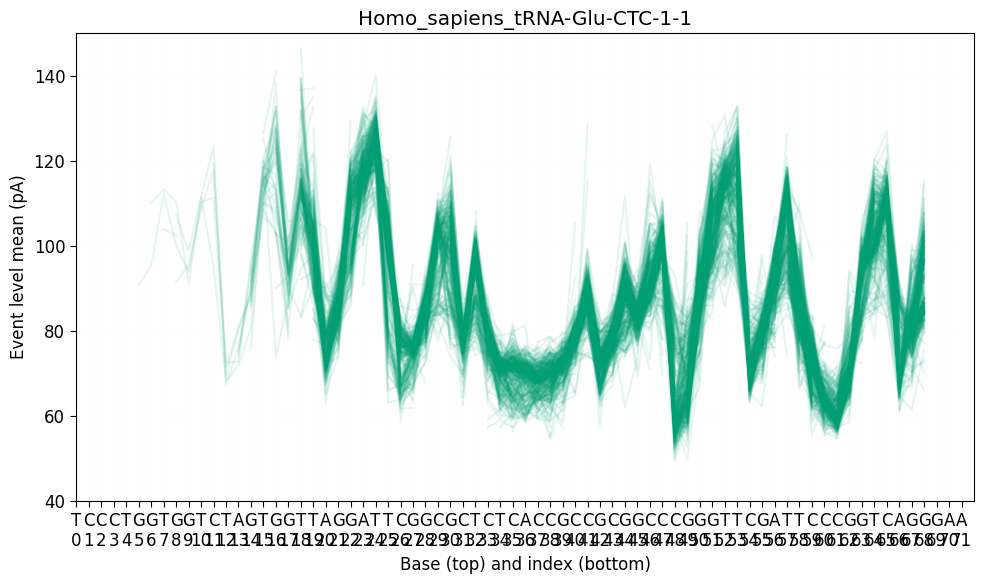

In [19]:
plot_event_level_means_one_sample_with_seq(
    f5c_output_bio_wide, 
    xlim_start = 0,
    xlim_end = 72,
    max_reads = 400, 
    alpha_lines = 1/10, 
    highlight_positions = None, 
    color = '#009E73', 
    sequence = seq_Glu_CTC_1_1)

#### IVT sample

Shape of metric array: (18707, 64)
Plotting 400 reads
The sequence being plotted is 72 nt


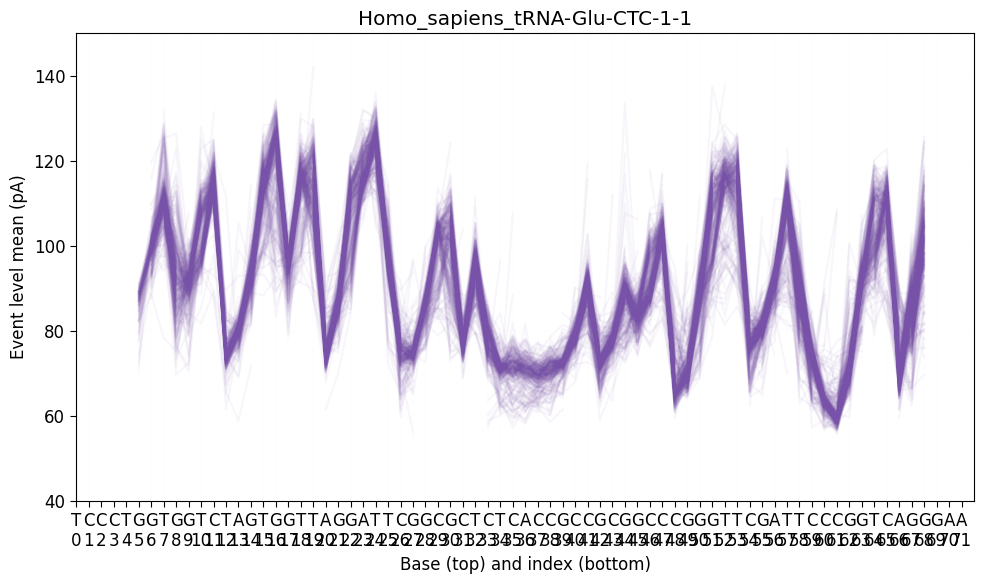

In [20]:
plot_event_level_means_one_sample_with_seq(
    f5c_output_IVT_wide,
    xlim_start = 0, 
    xlim_end = 72,
    max_reads = 400,
    alpha_lines = 1/20, 
    highlight_positions = None, 
    color = "#7851A9",      
    sequence = seq_Glu_CTC_1_1)

#### Biological vs IVT

Shape of metric array Biological: (361, 64)
Plotting 360 reads for Biological
Shape of metric array IVT: (18707, 64)
Plotting 360 reads for IVT
The sequence being plotted is 30 nt


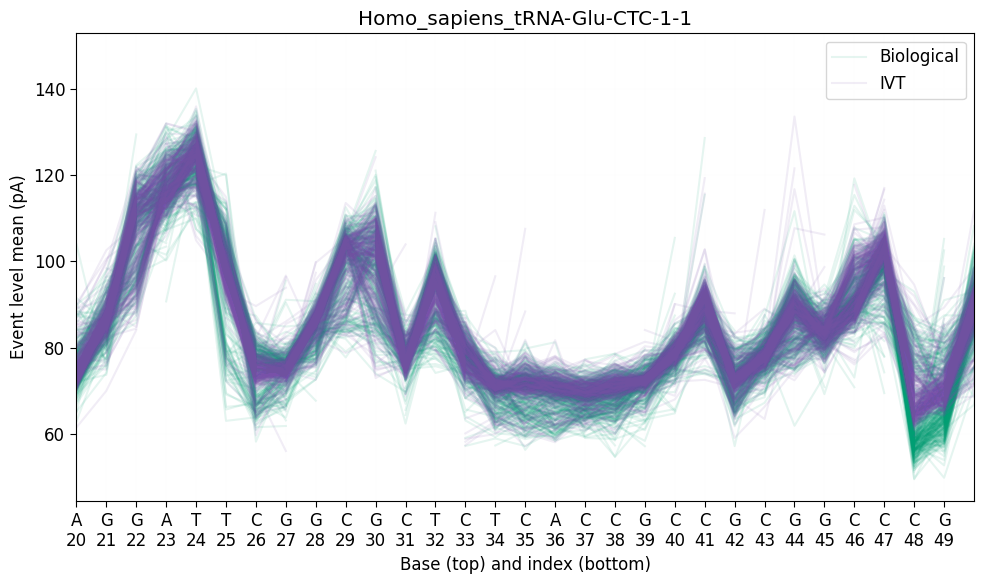

In [21]:
plot_event_level_means_two_samples_with_seq(
    f5c_output_bio_wide,
    f5c_output_IVT_wide,
    xlim_start=20,
    xlim_end=50,
    max_reads=360,
    alpha_lines=1/10,
    sample_labels=['Biological',  'IVT'],
    highlight_positions= None,
    sequence = seq_Glu_CTC_1_1
)

### Scatterplots: mean and std of trimmed mean signal levels

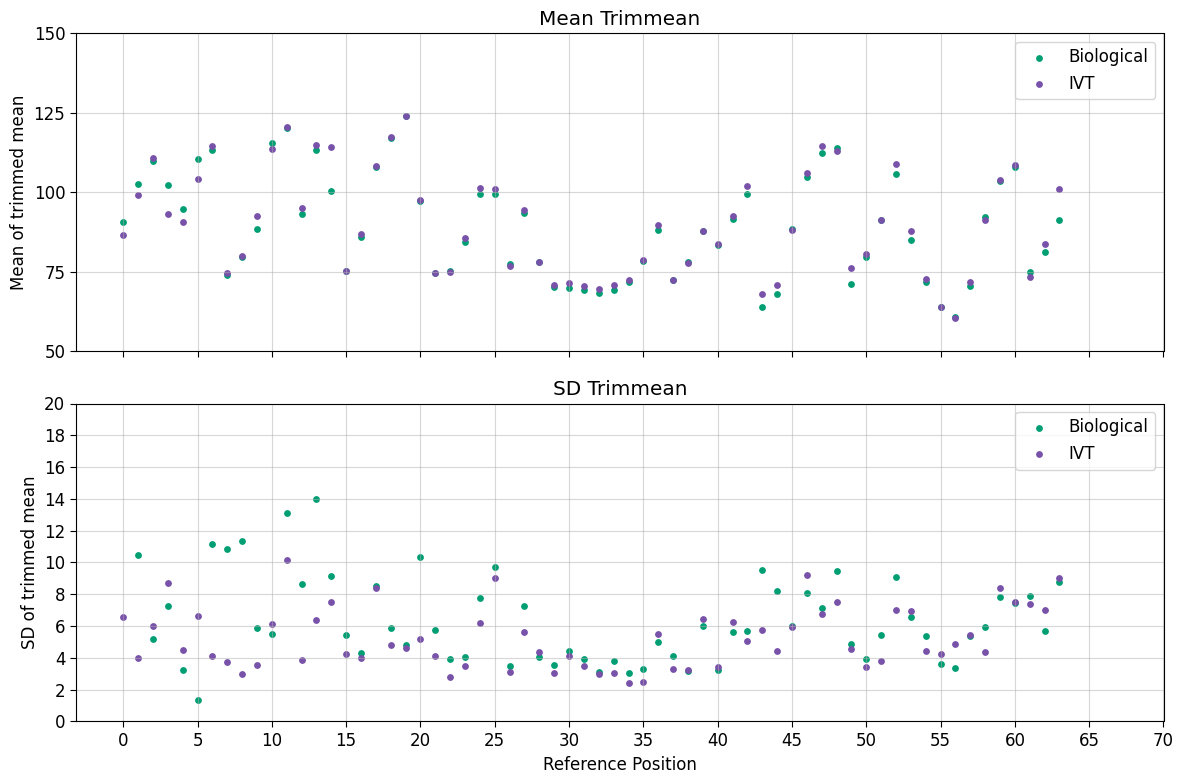

Mean SD values per sample:
Biological: 6.3467
IVT: 5.2706


In [22]:
plot_mean_and_sd_of_event_level_two_samples(
    event_level_df_1=f5c_output_bio_wide,
    event_level_df_2=f5c_output_IVT_wide,
    xlim_start = 0,
    xlim_end = 70,
    sample_labels = ['Biological', 'IVT'],
    colors=None 
)

### Violin plots

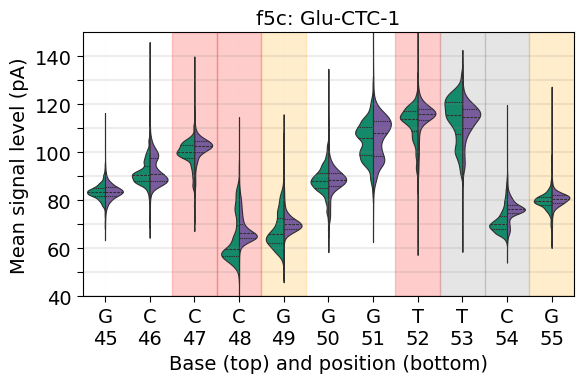

In [23]:
plot_event_level_means_violinplot_two(
    event_level_df_1 = f5c_output_bio_wide,
    event_level_df_2 = f5c_output_IVT_wide,
    sample_labels=["Biological", "IVT"],
    xlim_start=45,
    xlim_end=55,
    highlight_positions_one_ionic=None,
    highlight_positions_two_ionic = [49,55],
    highlight_positions_three = [47, 48, 52],
    highlight_positions_basecalled = None,
    highlight_positions_excluded = [53,54],
    sequence = seq_Glu_CTC_1_1,
    reference_of_interest= reference_of_interest, title = 'f5c: Glu-CTC-1', legend = 'no'
)

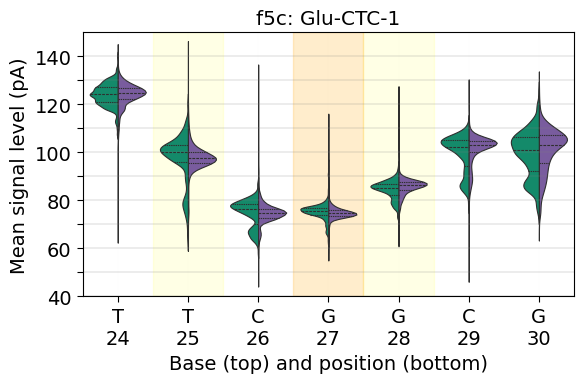

In [24]:
plot_event_level_means_violinplot_two(
    event_level_df_1 = f5c_output_bio_wide,
    event_level_df_2 = f5c_output_IVT_wide,
    sample_labels=["Biological", "IVT"],
    xlim_start=24,
    xlim_end=30,

    highlight_positions_one_ionic = [25, 28],
    highlight_positions_two_ionic = [27],
    highlight_positions_three = None,
    highlight_positions_basecalled = None,
    sequence = seq_Glu_CTC_1_1,
    reference_of_interest= reference_of_interest, title = 'f5c: Glu-CTC-1', legend = 'no'
)